__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. We are assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

In [ ]:
bad_nodes = [1,3,13]

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


# Create Federated Set Up

In [4]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [5]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

> __Passing in init decoders that are not (2, PCA_comps) AKA (2, 7) will result in the passed in dec getting overwritten to prevent matrix size mismatches.  Can't pass in the init dec from CPHS now because of PCA (unless you turn PCA off of course)__.

Check streaming condition

In [6]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check full data condition

In [7]:
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check advance_each_iter condition

In [8]:
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check the non-PCA case now... this is no longer the default
> This one should overwrite

In [9]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decode

## Double Checking Running the No-FL Case
> We should see some kind of convergence
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT

In [10]:
user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 0

Local Round: 0
Local Update: 0


In [11]:
global_model_no_fl.execute_FL_loop()

print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 1

Local Round: 1
Local Update: 1


In [12]:
# We are at update 2/19.  Therefore 19-2=17-1=16
num_updates_left = 16
for i in range(num_updates_left):
    if i%np.ceil(num_updates_left*.05)==0:
        print(f"Iter {i}")
    global_model_no_fl.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Iter 0
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Complete



Global Round: 17

Local Round: 17
Local Update: 17


In [13]:
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

17
17


Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...
> (3: darkorange), (13: deeppink), (1: maroon)

In [14]:
cost_array = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl.local_error_log[i]:
        cost_array[client_id, i] = error

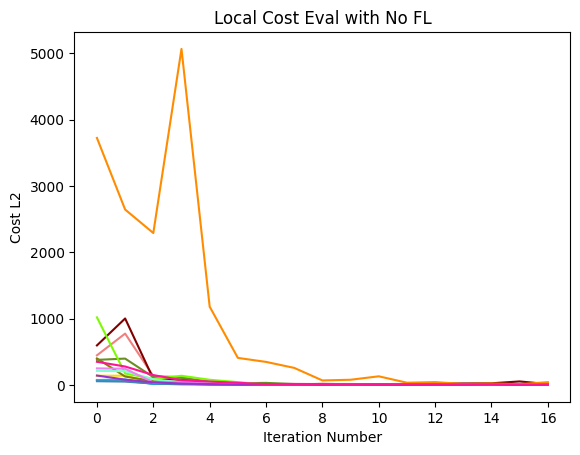

In [15]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval with No FL')
plt.show()

In [ ]:
external_plot_error(user_c0_fullscipy)

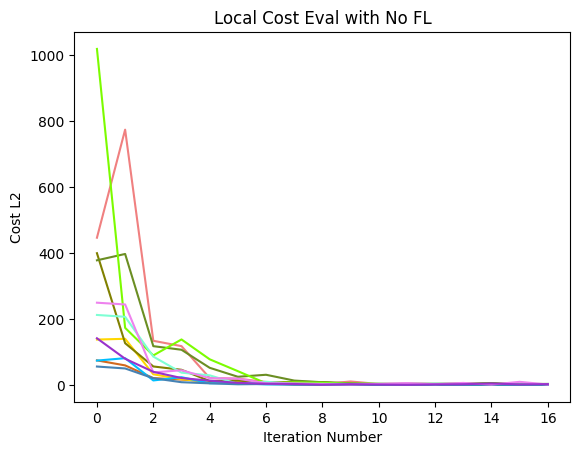

In [16]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

In [ ]:
xternal_plot_error(user_c0_fullscipy, exlusion_lst=bad_nodes)

Save Decs to compare to sims

In [17]:
all_user_decs_no_fl = [user_c0_fullscipy[i].dec_log for i in range(num_participants)]

#with open(path+nofl_decs_filename, 'wb') as fp:
#    pickle.dump(all_user_decs_no_fl, fp, protocol=pickle.HIGHEST_PROTOCOL)

__Retry but now use the init decs that we loaded in instead of the random inits__

In [18]:
user_c0_fullscipy_winit = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_winit = Server(-1, D_0, 'NoFL', user_c0_fullscipy_winit, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    if i%5==0:
        print(f"Iter {i}")
    global_model_no_fl_winit.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl_winit.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy_winit[0].current_round}")
print(f"Local Update: {user_c0_fullscipy_winit[0].current_update}")

Iter 0
Iter 5
Iter 10
Iter 15
Complete



Global Round: 18

Local Round: 18
Local Update: 17


In [19]:
cost_array_winit = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl_winit.local_error_log[i]:
        #plt.scatter(i, error, color=id2color[client_id])
        cost_array_winit[client_id, i] = error

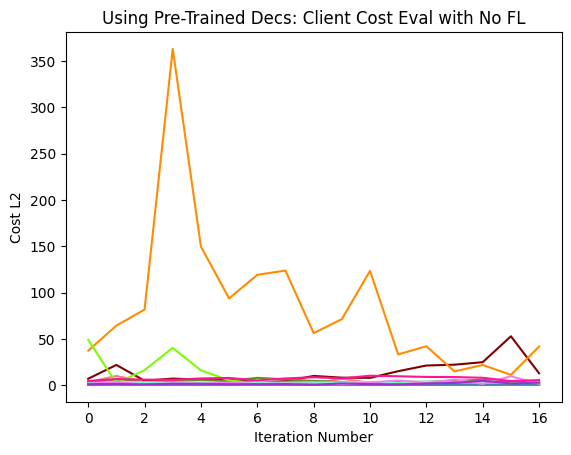

In [20]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Using Pre-Trained Decs: Client Cost Eval with No FL')
plt.show()

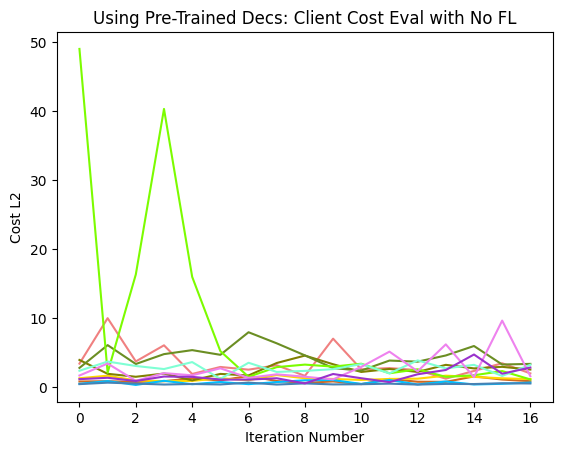

In [21]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Using Pre-Trained Decs: Client Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

## 1 Scipy Step, 1000 Iterations

In [22]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_1scipystep.execute_FL_loop()
print("Complete")

Iter 0
Iter 100
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 300
Iter 400
Iter 500
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 600
Iter 700
Iter 800
Iter 900
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1000
Iter 1100
Iter 1200
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1300
Iter 1400
Iter 1500
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1600
Iter 1700
Iter 1800
Iter 1900
Client 1: New update after lrt passed: (new update, current round): (16, 300)

Complete


In [23]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(276, 15)
(314, 16)
(285, 15)
(321, 16)
(269, 15)
(275, 15)
(281, 15)
(296, 15)
(270, 15)
(264, 15)
(289, 15)
(281, 15)
(297, 15)
(282, 15)


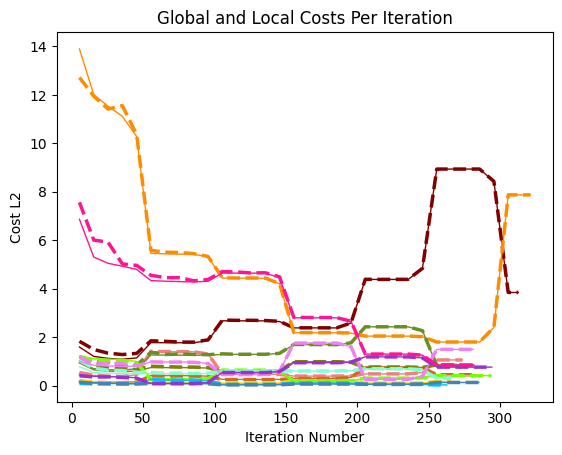

In [24]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_1ScipyStep[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global and Local Costs Per Iteration')
plt.show()

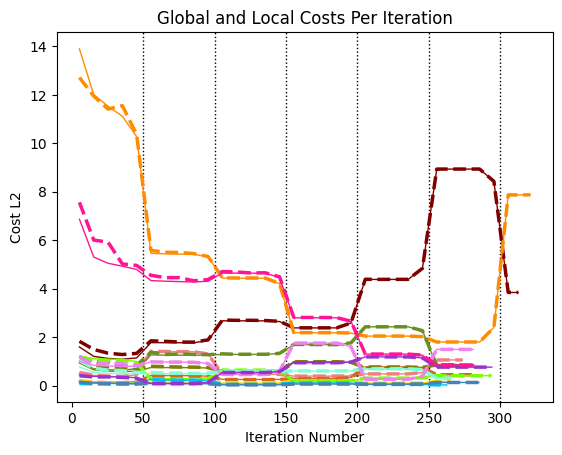

In [49]:
external_plot_error(user_c0_1ScipyStep)

__Redoing but setting the local threshold for update to be much lower__
> NOTE THAT I CHANGED THE DEFUALT LIM TO 50 IN THE CODE ANYWAYS SO THIS SHOULD BE THE SAME
> Is it completely deterministic?

In [54]:
reduced_limit = 50

user_c0_1ScipyStep_lim50 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim50 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim50)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_1scipystep_lim50.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1400
Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


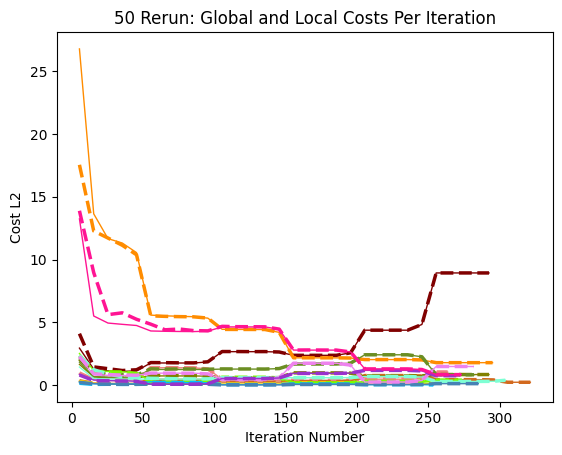

In [56]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('50 Rerun: Global and Local Costs Per Iteration')
plt.show()

__Repeat but now actually make it much smaller__

In [57]:
reduced_limit = 25

user_c0_1ScipyStep_lim25 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim25 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim25)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_1scipystep_lim25.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 25)

Client 1: New update after lrt passed: (new update, current round): (12, 50)

Iter 400
Client 1: New update after lrt passed: (new update, current round): (13, 75)

Iter 600
Client 1: New update after lrt passed: (new update, current round): (14, 100)

Iter 800
Client 1: New update after lrt passed: (new update, current round): (15, 125)

Iter 1000
Client 1: New update after lrt passed: (new update, current round): (16, 150)

Iter 1200
Client 1: New update after lrt passed: (new update, current round): (17, 175)

Iter 1400
Iter 1600
Iter 1800
Complete


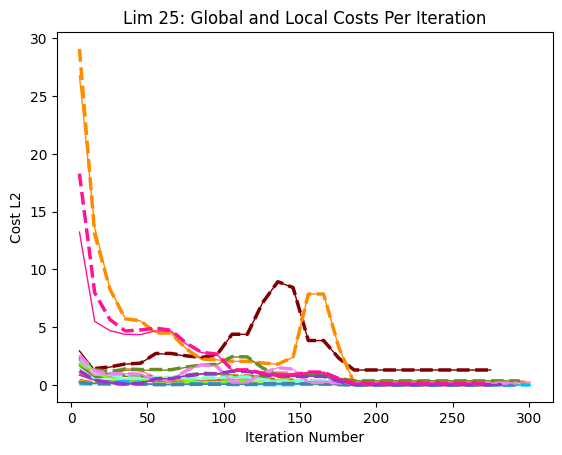

In [58]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim25[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_1ScipyStep_lim25[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Lim 25: Global and Local Costs Per Iteration')
plt.show()

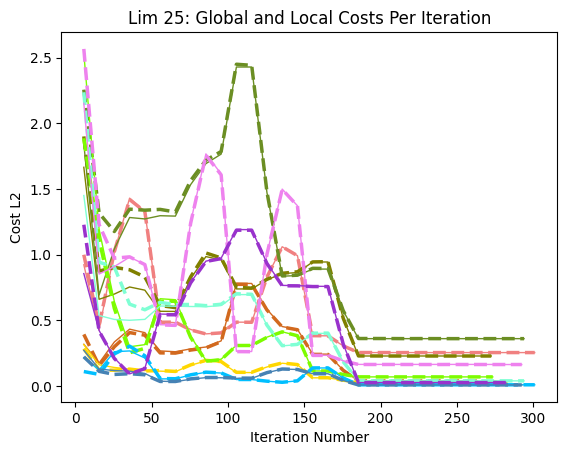

In [60]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim25[i].global_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')

        df = pd.DataFrame(user_c0_1ScipyStep_lim25[i].local_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Lim 25: Global and Local Costs Per Iteration')
plt.show()

__This time, use the final global model as the init instead of a random init__
> Compare against using the local model? Doesn't help for new clients...

In [42]:
global_model_1scipystep_lim50.w

array([[ 3.99176994e-04,  7.39934272e-04,  1.02116402e-03,
        -2.30515907e-03,  7.00401776e-04,  9.22336691e-03,
         3.84850853e-03],
       [-8.04942140e-04,  3.13985460e-04,  1.88370377e-03,
         3.64026626e-05, -5.50317426e-04, -3.81423096e-03,
         1.34151535e-02]])

In [43]:
user_c0_1ScipyStep_globaldec = [Client(i, global_model_1scipystep_lim50.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globaldecinit = Server(1, global_model_1scipystep_lim50.w, 'FedAvg', user_c0_1ScipyStep_globaldec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_globaldecinit.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 600
Iter 800
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 1000
Iter 1200
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1400
Iter 1600
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1800
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Complete


In [34]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(285, 15)
(297, 15)
(270, 15)
(293, 15)
(253, 15)
(285, 15)
(304, 16)
(283, 15)
(306, 16)
(271, 15)
(298, 15)
(280, 15)
(280, 15)
(295, 15)


## Why are the local and global error logs the exact same here.  This is the only case where this happens I think

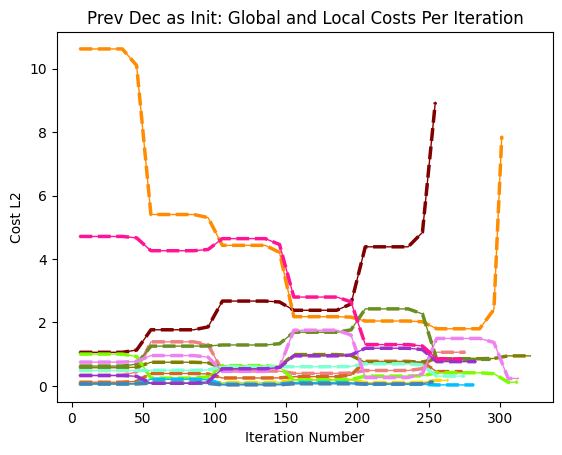

In [59]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Global and Local Costs Per Iteration')
plt.show()

I can't tell much difference between the sets of plots, using the Previous Global Dec as the init...

__Retry but use both prev local AND global models__

In [84]:
user_c0_1ScipyStep_globalandlocaldec = [Client(i, user_c0_1ScipyStep_lim50[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globalandlocaldec = Server(1, global_model_1scipystep_lim50.w, 'FedAvg', user_c0_1ScipyStep_globalandlocaldec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_globalandlocaldec.execute_FL_loop()
print("Complete")

Iter 0
Client 1: New update after lrt passed: (new update, current round): (11, 25)

Iter 200
Client 1: New update after lrt passed: (new update, current round): (12, 50)

Iter 400
Client 1: New update after lrt passed: (new update, current round): (13, 75)

Iter 600
Client 1: New update after lrt passed: (new update, current round): (14, 100)

Iter 800
Client 1: New update after lrt passed: (new update, current round): (15, 125)

Iter 1000
Client 1: New update after lrt passed: (new update, current round): (16, 150)

Iter 1200
Client 1: New update after lrt passed: (new update, current round): (17, 175)

Iter 1400
Iter 1600
Iter 1800
Complete


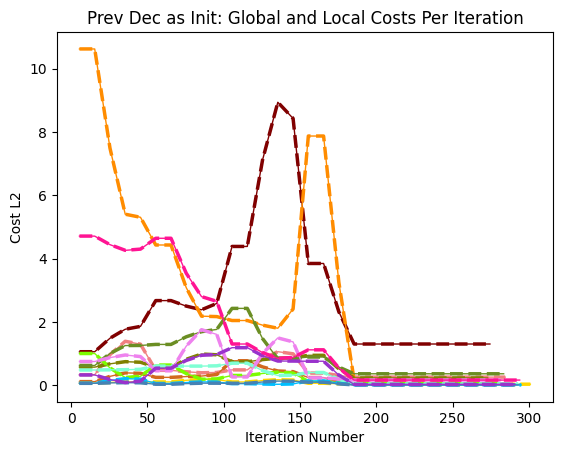

In [88]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_globalandlocaldec[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_1ScipyStep_globalandlocaldec[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Global and Local Costs Per Iteration')
plt.show()

## 10 Steps

In [62]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_10scipy.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800
Complete


In [63]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(280, 15)
(258, 15)
(276, 15)
(301, 16)
(266, 15)
(321, 16)
(295, 15)
(313, 16)
(279, 15)
(282, 15)
(255, 15)
(314, 16)
(285, 15)
(275, 15)


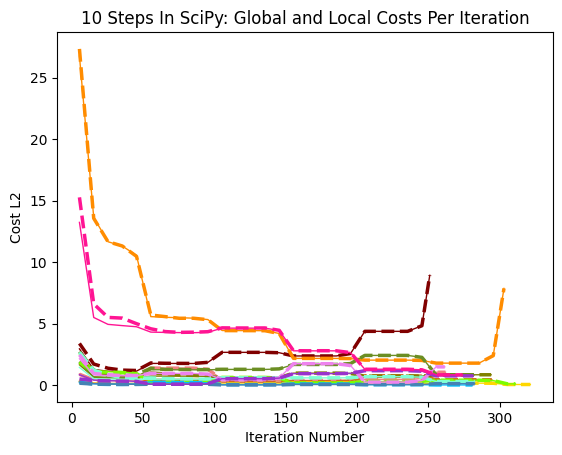

In [64]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_10scipy[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_10scipy[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Steps In SciPy: Global and Local Costs Per Iteration')
plt.show()

__I'll retry now but using the final global model from above__

In [81]:
user_c0_10scipy_prevdec = [Client(i, global_model_10scipy.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_prevdec = Server(2, global_model_10scipy.w, 'FedAvg', user_c0_10scipy_prevdec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_10scipy_prevdec.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800
Complete


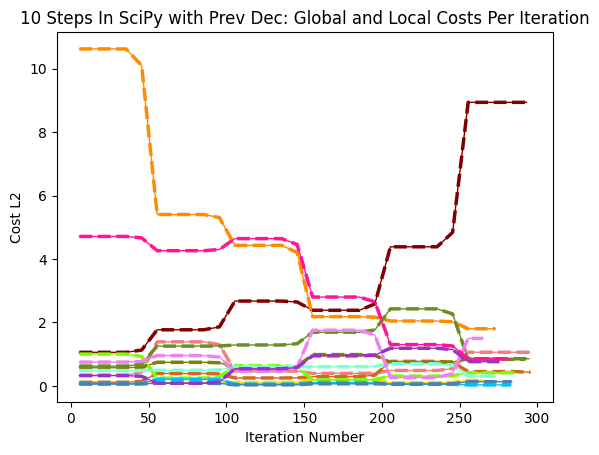

In [82]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_10scipy_prevdec[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_10scipy_prevdec[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Steps In SciPy with Prev Dec: Global and Local Costs Per Iteration')
plt.show()

__I'll retry now but using the final global AND local models from the run above the above__

In [89]:
user_c0_10scipy_ALLprevdec = [Client(i, user_c0_10scipy[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_ALLprevdec = Server(2, global_model_10scipy.w, 'FedAvg', user_c0_10scipy_ALLprevdec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.05)==0:
        print(f"Iter {i}")
    global_model_10scipy_ALLprevdec.execute_FL_loop()
print("Complete")

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900
Iter 1000
Iter 1100
Iter 1200
Iter 1300
Iter 1400
Iter 1500
Iter 1600
Iter 1700
Iter 1800
Iter 1900
Complete


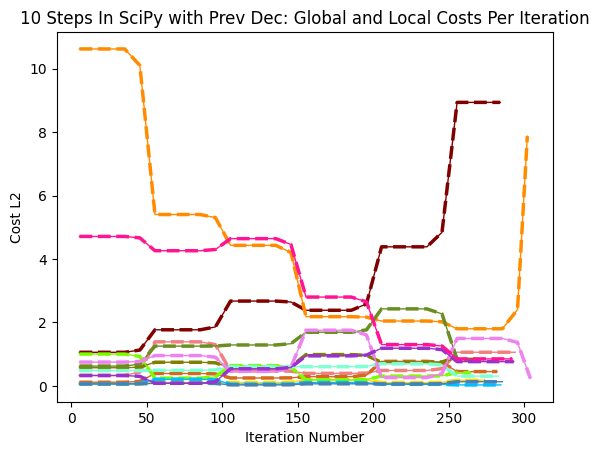

In [90]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_10scipy_ALLprevdec[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_10scipy_ALLprevdec[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Steps In SciPy with Prev Dec: Global and Local Costs Per Iteration')
plt.show()

## Full Scipy.Minimize

In [66]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(18):
    if i%np.ceil(18*.05)==0:
        print(f"Iter {i}")
    global_model_fullscipy.execute_FL_loop()
print("Complete")

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Complete


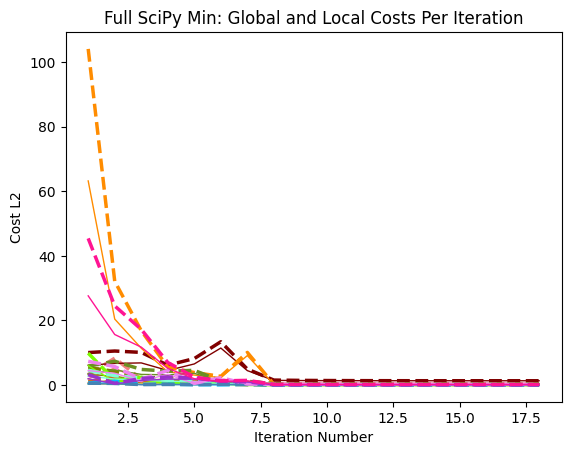

In [74]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].global_error_log)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=2.5, linestyle='--')
    
    df = pd.DataFrame(user_c0_fullscipy[i].local_error_log)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=1)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Full SciPy Min: Global and Local Costs Per Iteration')
plt.show()